In [1]:
! pip install supervision

   ---------------------------------------- 0.0/212.4 kB ? eta -:--:--
   - -------------------------------------- 10.2/212.4 kB ? eta -:--:--
   ------------- -------------------------- 71.7/212.4 kB 1.3 MB/s eta 0:00:01
   ----------------------- ---------------- 122.9/212.4 kB 1.2 MB/s eta 0:00:01
   ------------------------------------ --- 194.6/212.4 kB 1.2 MB/s eta 0:00:01
   ---------------------------------------- 212.4/212.4 kB 1.1 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\moham\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import os
from pathlib import Path
import json
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import supervision as sv
import pandas as pd
from collections import deque

### Output here your path for the video and the folder 

In [5]:
video_input_path = "/Users/hugostubler/Documents/Quantum Sport Analytics/Tennis/tennis-ai/data/videos/Alcaraz_Sinner_2025.mp4"
folder_path = "/Users/hugostubler/Documents/Quantum Sport Analytics/Tennis/tennis-analytics/data"
#folder_path_back = f"{folder_path}/back/per_point_v2"
folder_path_back = r"C:\Users\moham\Desktop\AI_perso\Quantum Analytics\per_point_v2"
video_intermediate_path = "annotated_hits_overlay.mp4"


## Several functions to overlay the video and to plot the hit & bounce on time series

In [88]:
def get_jsons(i, folder_path_back):

    # Load in another notebook
    with open(f"{folder_path_back}/ball_data_{i}.json", 'r') as f:
        dico_ball = json.load(f)

    return dico_ball



def extract_subvideo_by_frames(mp4_file_string, start_int, end_int, output_path=None):
    # Create output path based on input file name and frame range
    if output_path is None:
        output_path = mp4_file_string.split(".mp4")[0] + f'extract{start_int}_{end_int}.mp4'

    # Open the video file
    cap = cv2.VideoCapture(mp4_file_string)

    # Get the total number of frames and fps in the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)  # Read the original fps

    # Ensure start and end are within the frame range
    if start_int < 0 or end_int >= total_frames or start_int > end_int:
        raise ValueError(f"Invalid frame range: start_int={start_int}, end_int={end_int}, total_frames={total_frames}")

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 'mp4v' for .mp4 files
    out = cv2.VideoWriter(output_path, fourcc, fps, (int(cap.get(3)), int(cap.get(4))))
    
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_int)

    # Loop through and write the selected frames
    for frame_num in range(start_int, end_int + 1):
        ret, frame = cap.read()
        if not ret:
            break
        out.write(frame)

    # Release resources
    cap.release()
    out.release()

    ### Return the absolute path of the output video
    return os.path.abspath(output_path)


def create_video_full_overlay(
    input_video_path,
    dico_ball,
    output_video_path,
    ball_show=True,
    bounce_show=True,
    hit_show=True,
    tail_duration=1.5,
    global_start_frame=0,

):
    """
    - dico_ball: {global_frame_str or int: {"x": ..., "y": ..., "action": "air"/"bounce"/"hit", "visible": bool}}
    - dico_shots: list[dict] or dict[...] with 'frame', 'player name', 'type', 'speed'
    """
    cap = cv2.VideoCapture(input_video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Changed codec to mp4v for better compatibility
    out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    # Ball tail: controlled by tail_duration
    ball_tail_length = int(tail_duration * fps)

    # Ball data as DataFrame
    df = pd.DataFrame.from_dict(dico_ball, orient='index')
    df.index = df.index.astype(int)
    df = df.sort_index()
    df[['x', 'y']] = df[['x', 'y']].astype('float')
    df['x_interp'] = df['x'].interpolate(limit_direction='both')
    df['y_interp'] = df['y'].interpolate(limit_direction='both')

    frame_idx_local = 0
    ball_tail_buffer = deque()
    bounce_positions = []
    hit_positions = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        global_frame_idx = global_start_frame + frame_idx_local

        # --- BALL & HITS OVERLAYS ---
        if global_frame_idx in df.index:
            row = df.loc[global_frame_idx]
            x, y = int(row['x_interp']), int(row['y_interp'])
            action = dico_ball.get(str(global_frame_idx), {}).get("action", "air")

            if ball_show:
                ball_tail_buffer.append((x, y, frame_idx_local))
                while ball_tail_buffer and frame_idx_local - ball_tail_buffer[0][2] > ball_tail_length:
                    ball_tail_buffer.popleft()
                for j in range(1, len(ball_tail_buffer)):
                    x1, y1, f1 = ball_tail_buffer[j - 1]
                    x2, y2, f2 = ball_tail_buffer[j]
                    if None in [x1, y1, x2, y2]:
                        continue

                    color = (0, 255, 255)
                    cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), color, 3)

            if bounce_show:
                if action == "bounce":
                    bounce_positions.append((x, y))
                for bx, by in bounce_positions:
                    cv2.ellipse(frame, (bx, by), (12, 6), 0, 0, 360, (0, 255, 255), 2)

            if hit_show:
                if action == "hit":
                    hit_positions.append((x, y))
                # Fixed: was iterating bounce_positions instead of hit_positions
                for hx, hy in hit_positions:
                    cv2.circle(frame, (hx, hy), 20, (255, 0, 0), 2)
                    cv2.line(frame, (hx - 10, hy - 10), (hx + 10, hy + 10), (255, 0, 0), 2)
                    cv2.line(frame, (hx - 10, hy + 10), (hx + 10, hy - 1), (255, 0, 0), 2)

        # CRITICAL FIX: Write the frame to output video!
        out.write(frame)
        frame_idx_local += 1

    cap.release()
    out.release()
    print(f"✅ Full overlay video saved to: {output_video_path}")


import numpy as np
import matplotlib.pyplot as plt

# Example inputs
# dico_ball = { ... }  # your dict
# hits = [frame_ids...]
# bounces = [frame_ids...]

def plot_ball_timeseries(point_ID):
    
    with open(f'{folder_path_back}/ball_data_{point_ID}.json', 'r') as file:
        ball_data = json.load(file)
    ball_data = {int(frame): data for frame, data in ball_data.items()}
    
    bounces_data = {}
    hits_data = {}

    # ---- Iterate through all frames ----
    for frame_str, info in ball_data.items():
        action = info.get("action", None)
        frame = int(frame_str)

        if action == "bounce":
            bounces_data[frame] = info

        elif action == "hit":
            hits_data[frame] = info


    dico_ball = ball_data
    hits = hits_data
    bounces = bounces_data
    # 1) Sort frames and build arrays
    frames = sorted(dico_ball.keys())

    frames_visible = []
    x_vals = []
    y_vals = []

    for f in frames:
        d = dico_ball[f]
        # keep only visible points with valid x,y
        if d.get("visible") and d.get("x") is not None and d.get("y") is not None:
            frames_visible.append(f)
            x_vals.append(d["x"])
            y_vals.append(d["y"])

    frames_visible = np.array(frames_visible)
    x_vals = np.array(x_vals, dtype=float)
    y_vals = np.array(y_vals, dtype=float)

    # 2) Create figure with 2 subplots: x vs frame, y vs frame
    fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
    ax_x, ax_y = axes

    # Plot x
    ax_x.plot(frames_visible, x_vals, linestyle='-', label='x (pixels)')
    ax_x.set_ylabel("x (pixels)")
    ax_x.legend(loc="upper left")

    # Plot y
    ax_y.plot(frames_visible, y_vals, linestyle='-', label='y (pixels)')
    ax_y.set_ylabel("y (pixels)")
    ax_y.set_xlabel("Frame")
    ax_y.legend(loc="upper left")

    # 3) Add vertical lines for hits (green) and bounces (red)
    hits = sorted(hits)
    bounces = sorted(bounces)

    for h in hits:
        ax_x.axvline(h, color='g', linestyle='--', alpha=0.7, label='Hit')
        ax_y.axvline(h, color='g', linestyle='--', alpha=0.7, label='Hit')

    for b in bounces:
        ax_x.axvline(b, color='r', linestyle='--', alpha=0.7,  label='Bounce')
        ax_y.axvline(b, color='r', linestyle='--', alpha=0.7,label='Bounce')

    # Optional: x-limits around data & events
    all_frames_for_limits = frames_visible.tolist() + hits + bounces
    if all_frames_for_limits:
        x_min = min(all_frames_for_limits) - 5
        x_max = max(all_frames_for_limits) + 5
        ax_x.set_xlim(x_min, x_max)

    plt.tight_layout()
    plt.legend()
    plt.show()

# Call it
# plot_ball_timeseries(dico_ball, hits, bounces)



In [16]:
def plot_ball_velocity_timeseries(point_ID):
    
    with open(f'{folder_path_back}/ball_data_{point_ID}.json', 'r') as file:
        ball_data = json.load(file)
    ball_data = {int(frame): data for frame, data in ball_data.items()}

    hits = []
    bounces = []

    for frame, info in ball_data.items():
        if info.get("action") == "hit":
            hits.append(frame)
        elif info.get("action") == "bounce":
            bounces.append(frame)

    frames = sorted(ball_data.keys())

    frames_visible = []
    x_vals = []
    y_vals = []

    for f in frames:
        d = ball_data[f]
        if d.get("visible") and d.get("x") is not None and d.get("y") is not None:
            frames_visible.append(f)
            x_vals.append(d["x"])
            y_vals.append(d["y"])

    frames_visible = np.array(frames_visible)
    x_vals = np.array(x_vals, dtype=float)
    y_vals = np.array(y_vals, dtype=float)

    # Discrete derivatives
    dx = np.diff(x_vals)
    dy = np.diff(y_vals)
    frames_d = frames_visible[1:]

    fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
    ax_dx, ax_dy = axes

    ax_dx.plot(frames_d, dx, linestyle='-', label='dx')
    ax_dx.set_ylabel("dx (pixels/frame)")
    ax_dx.legend(loc="upper left")

    ax_dy.plot(frames_d, dy, linestyle='-', label='dy')
    ax_dy.set_ylabel("dy (pixels/frame)")
    ax_dy.set_xlabel("Frame")
    ax_dy.legend(loc="upper left")

    for h in hits:
        ax_dx.axvline(h, color='g', linestyle='--', alpha=0.7)
        ax_dy.axvline(h, color='g', linestyle='--', alpha=0.7)

    for b in bounces:
        ax_dx.axvline(b, color='r', linestyle='--', alpha=0.7)
        ax_dy.axvline(b, color='r', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


In [17]:
def plot_ball_acceleration_timeseries(point_ID):
    
    with open(f'{folder_path_back}/ball_data_{point_ID}.json', 'r') as file:
        ball_data = json.load(file)
    ball_data = {int(frame): data for frame, data in ball_data.items()}

    hits = []
    bounces = []

    for frame, info in ball_data.items():
        if info.get("action") == "hit":
            hits.append(frame)
        elif info.get("action") == "bounce":
            bounces.append(frame)

    frames = sorted(ball_data.keys())

    frames_visible = []
    x_vals = []
    y_vals = []

    for f in frames:
        d = ball_data[f]
        if d.get("visible") and d.get("x") is not None and d.get("y") is not None:
            frames_visible.append(f)
            x_vals.append(d["x"])
            y_vals.append(d["y"])

    frames_visible = np.array(frames_visible)
    x_vals = np.array(x_vals, dtype=float)
    y_vals = np.array(y_vals, dtype=float)

    # Second discrete derivatives
    d2x = np.diff(x_vals, n=2)
    d2y = np.diff(y_vals, n=2)
    frames_d2 = frames_visible[2:]

    fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
    ax_d2x, ax_d2y = axes

    ax_d2x.plot(frames_d2, d2x, linestyle='-', label='d²x')
    ax_d2x.set_ylabel("d²x (pixels/frame²)")
    ax_d2x.legend(loc="upper left")

    ax_d2y.plot(frames_d2, d2y, linestyle='-', label='d²y')
    ax_d2y.set_ylabel("d²y (pixels/frame²)")
    ax_d2y.set_xlabel("Frame")
    ax_d2y.legend(loc="upper left")

    for h in hits:
        ax_d2x.axvline(h, color='g', linestyle='--', alpha=0.7)
        ax_d2y.axvline(h, color='g', linestyle='--', alpha=0.7)

    for b in bounces:
        ax_d2x.axvline(b, color='r', linestyle='--', alpha=0.7)
        ax_d2y.axvline(b, color='r', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


In [22]:
from scipy.signal import savgol_filter
import json
import numpy as np
import matplotlib.pyplot as plt


def plot_ball_velocity_timeseries_smooth(point_ID,
                                         window_length=11,
                                         polyorder=2):
    """
    Plot dx and dy after smoothing x(t), y(t) using Savitzky-Golay filter.
    """

    # ---- Load data ----
    with open(f'{folder_path_back}/ball_data_{point_ID}.json', 'r') as file:
        ball_data = json.load(file)

    ball_data = {int(frame): data for frame, data in ball_data.items()}

    hits = []
    bounces = []

    for frame, info in ball_data.items():
        if info.get("action") == "hit":
            hits.append(frame)
        elif info.get("action") == "bounce":
            bounces.append(frame)

    frames = sorted(ball_data.keys())

    frames_visible = []
    x_vals = []
    y_vals = []

    for f in frames:
        d = ball_data[f]
        if d.get("visible") and d.get("x") is not None and d.get("y") is not None:
            frames_visible.append(f)
            x_vals.append(d["x"])
            y_vals.append(d["y"])

    frames_visible = np.array(frames_visible)
    x_vals = np.array(x_vals, dtype=float)
    y_vals = np.array(y_vals, dtype=float)

    # ---- Smooth positions BEFORE differentiation ----
    x_smooth = savgol_filter(x_vals, window_length=window_length, polyorder=polyorder)
    y_smooth = savgol_filter(y_vals, window_length=window_length, polyorder=polyorder)

    # ---- Discrete velocities ----
    dx = np.diff(x_smooth)
    dy = np.diff(y_smooth)
    frames_d = frames_visible[1:]

    # ---- Plot ----
    fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
    ax_dx, ax_dy = axes

    ax_dx.plot(frames_d, dx, linestyle='-', label='dx (smoothed)')
    ax_dx.set_ylabel("dx (pixels/frame)")
    ax_dx.legend(loc="upper left")

    ax_dy.plot(frames_d, dy, linestyle='-', label='dy (smoothed)')
    ax_dy.set_ylabel("dy (pixels/frame)")
    ax_dy.set_xlabel("Frame")
    ax_dy.legend(loc="upper left")

    # ---- Hit / Bounce markers ----
    for h in hits:
        ax_dx.axvline(h, color='g', linestyle='--', alpha=0.7)
        ax_dy.axvline(h, color='g', linestyle='--', alpha=0.7)

    for b in bounces:
        ax_dx.axvline(b, color='r', linestyle='--', alpha=0.7)
        ax_dy.axvline(b, color='r', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


# Plotting the video with Hit & Bounce overlays

In [10]:
# You can create a list of points you want to analyse the int is the point ID 
list_points_1 = [4] #[4, 12, 33, 58, 79, 102, 145, 163, 187, 201]

In [11]:
for point_selected in list_points_1:
    video_output_path = f"front_overlay_{point_selected}.mp4"
    print(f"Processing point {point_selected}...")
    dico_ball = get_jsons(point_selected, folder_path_back)

    first_key = next(iter(dico_ball))
    first_element = {first_key: dico_ball[first_key]}
    last_key = next(reversed(dico_ball))
    last_elem = {last_key: dico_ball[last_key]}

    # FIXED: Use a temporary variable instead of overwriting video_input_path
    extracted_video_path = extract_subvideo_by_frames(video_input_path, int(first_key), int(last_key), output_path=None)
    print(f"Subvideo extracted for point {point_selected}.")
    print(f"Creating overlay video for point {point_selected}...")
    create_video_full_overlay(
    input_video_path=extracted_video_path,
    dico_ball=dico_ball,
    output_video_path=video_output_path,
    ball_show=True,
    bounce_show=True,
    hit_show=True,
    tail_duration=1.5,
    global_start_frame=int(first_key),  # FIXED: Use actual first frame number!

    )
    
    print(f"Overlay video created for point {point_selected} !")

Processing point 4...
Subvideo extracted for point 4.
Creating overlay video for point 4...
✅ Full overlay video saved to: front_overlay_4.mp4
Overlay video created for point 4 !


# Code for plotting the Hit & Bounce on the x,y time series

In [7]:
point_ID = 111

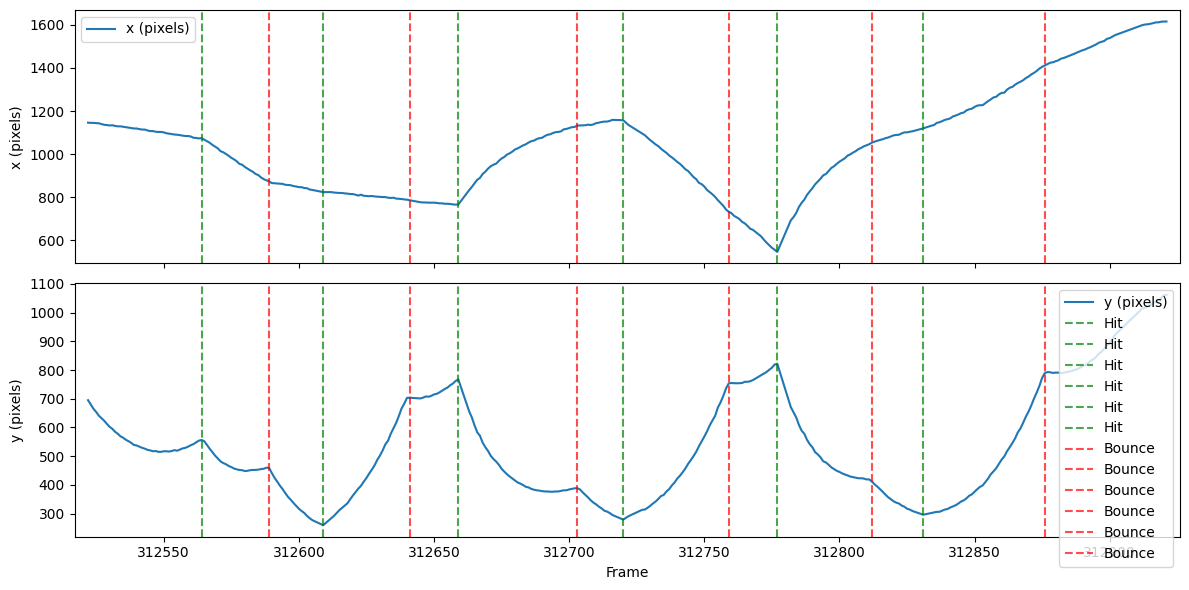

In [89]:
plot_ball_timeseries(point_ID)

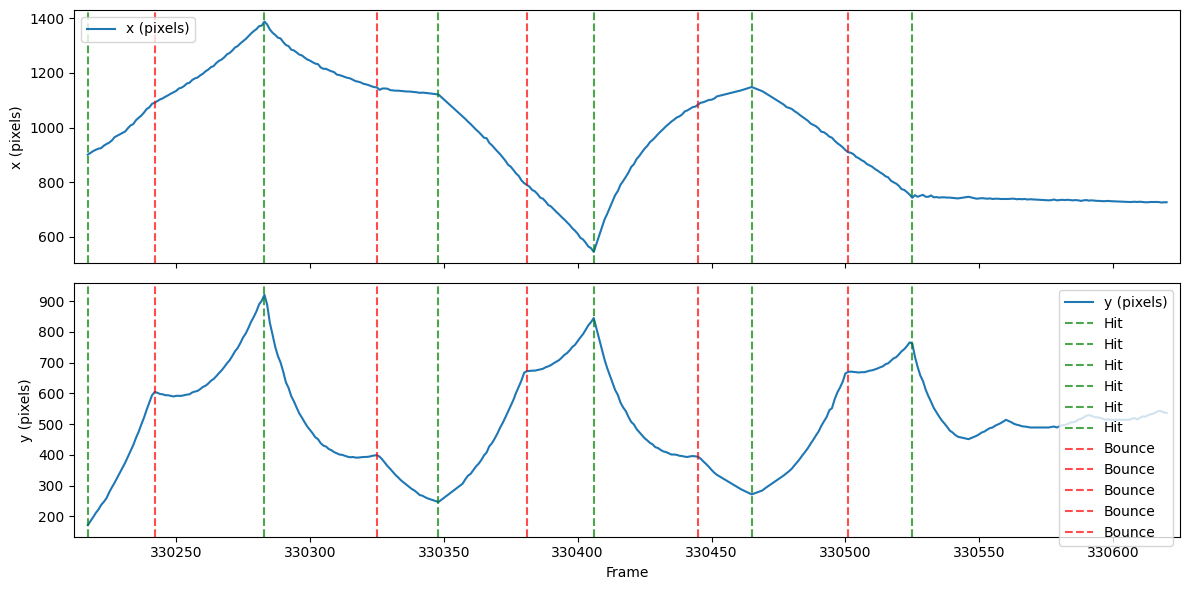

In [90]:
plot_ball_timeseries(117)

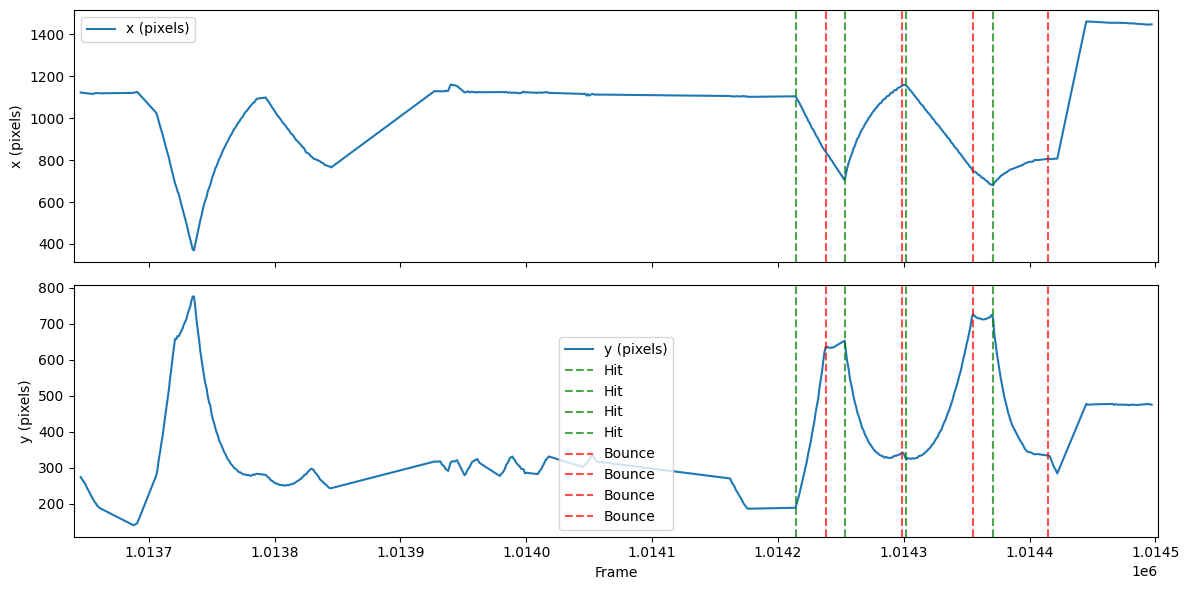

In [92]:
plot_ball_timeseries(378)

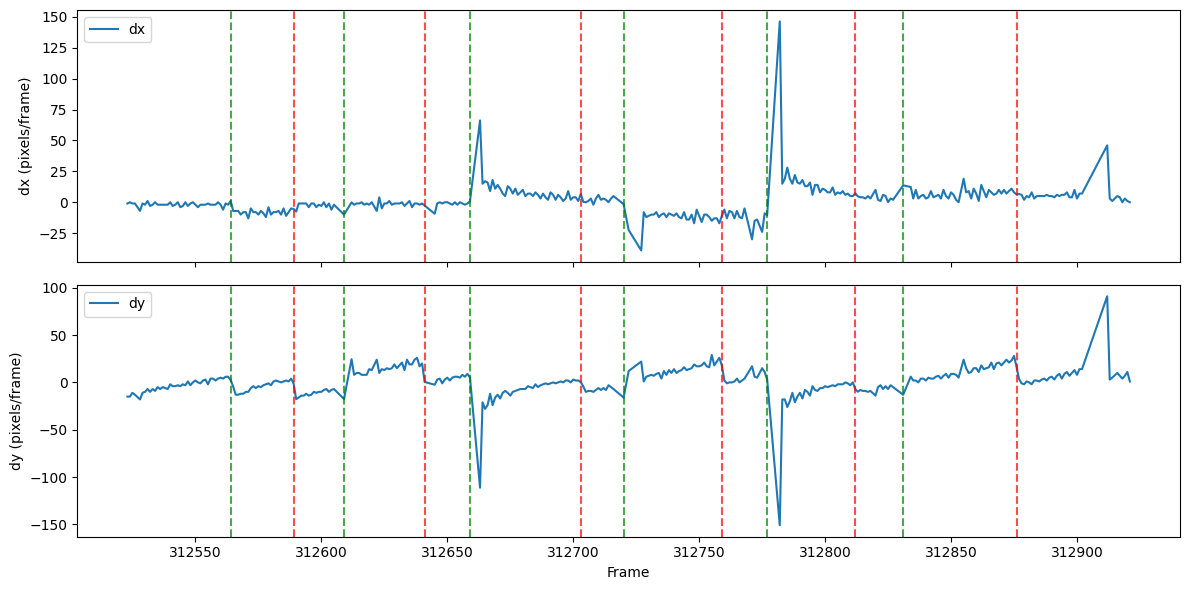

In [31]:
plot_ball_velocity_timeseries(point_ID)

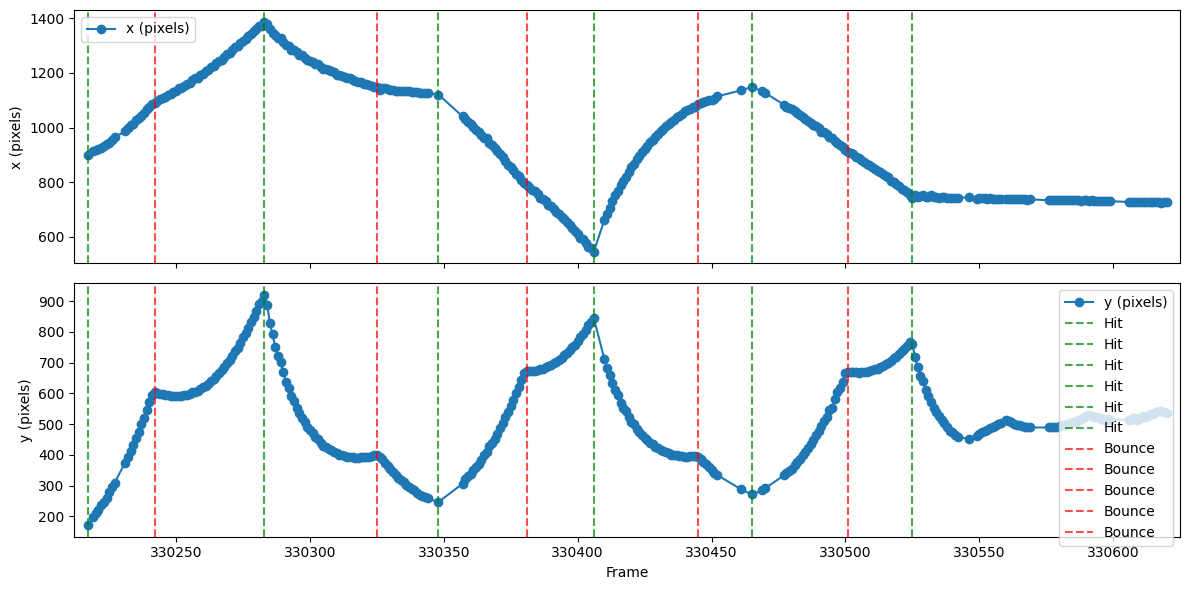

In [32]:
plot_ball_timeseries(117)

In [ ]:
for i in range(25):
    try :
        plot_ball_velocity_timeseries(i)
    except Exception :
        continue
    

In [33]:
import os

MIN_VISIBLE_FRAMES = 30


def compute_delta_xy_statistics(folder_path):
    air_dx, air_dy = [], []
    bounce_dx, bounce_dy = [], []
    hit_dx, hit_dy = [], []

    for filename in os.listdir(folder_path):
        if not filename.endswith(".json"):
            continue

        with open(os.path.join(folder_path, filename), "r") as f:
            data = json.load(f)

        # Convert frame keys to int and sort
        data = {int(k): v for k, v in data.items()}
        frames = sorted(data.keys())

        frames_visible = []
        x_vals, y_vals, labels = [], [], []

        for f in frames:
            d = data[f]
            if d.get("visible") and d.get("x") is not None and d.get("y") is not None:
                frames_visible.append(f)
                x_vals.append(d["x"])
                y_vals.append(d["y"])
                labels.append(d.get("action"))

        if len(x_vals) < MIN_VISIBLE_FRAMES:
            continue

        x_vals = np.array(x_vals, dtype=float)
        y_vals = np.array(y_vals, dtype=float)

        dx = np.diff(x_vals)
        dy = np.diff(y_vals)

        labels_dxdy = labels[1:]  # align with dx, dy

        for i, label in enumerate(labels_dxdy):
            if label == "air":
                air_dx.append(abs(dx[i]))
                air_dy.append(abs(dy[i]))

            elif label == "bounce":
                bounce_dx.append(abs(dx[i]))
                bounce_dy.append(abs(dy[i]))

            elif label == "hit":
                hit_dx.append(abs(dx[i]))
                hit_dy.append(abs(dy[i]))

    return {
        "air": {
            "dx": np.array(air_dx),
            "dy": np.array(air_dy),
        },
        "bounce": {
            "dx": np.array(bounce_dx),
            "dy": np.array(bounce_dy),
        },
        "hit": {
            "dx": np.array(hit_dx),
            "dy": np.array(hit_dy),
        }
    }


In [40]:
def plot_delta_xy_by_type_fixed_scale(stats, bins=100):

    all_dx = np.concatenate([stats[k]["dx"] for k in stats if len(stats[k]["dx"]) > 0])
    all_dy = np.concatenate([stats[k]["dy"] for k in stats if len(stats[k]["dy"]) > 0])

    xlim_dx = (0, np.percentile(all_dx, 99.5))
    xlim_dy = (0, np.percentile(all_dy, 99.5))

    for action in ["air", "bounce", "hit"]:

        dx = stats[action]["dx"]
        dy = stats[action]["dy"]

        if len(dx) == 0:
            continue

        fig, axes = plt.subplots(1, 2, figsize=(10, 4))

        axes[0].hist(dx, bins=bins, alpha=0.7)
        axes[0].set_xlim(xlim_dx)
        axes[0].set_title(f"{action.upper()} – |Δx|")
        axes[0].grid(True)

        axes[1].hist(dy, bins=bins, alpha=0.7)
        axes[1].set_xlim(xlim_dy)
        axes[1].set_title(f"{action.upper()} – |Δy|")
        axes[1].grid(True)

        plt.suptitle(f"{action.upper()} distributions (fixed scale)")
        plt.tight_layout()
        plt.show()


In [36]:
def plot_delta_xy_histograms(stats, bins=100):
    """
    Histogram comparison of |dx| and |dy| for air, bounce and hit.
    """

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # ---- |dx| ----
    axes[0].hist(
        stats["air"]["dx"],
        bins=bins,
        alpha=0.5,
        density=True,
        label="air"
    )
    axes[0].hist(
        stats["bounce"]["dx"],
        bins=bins,
        alpha=0.5,
        density=True,
        label="bounce"
    )
    axes[0].hist(
        stats["hit"]["dx"],
        bins=bins,
        alpha=0.5,
        density=True,
        label="hit"
    )

    axes[0].set_xlabel("|Δx|")
    axes[0].set_ylabel("Density")
    axes[0].set_title("Distribution of |Δx|")
    axes[0].legend()
    axes[0].grid(True)

    # ---- |dy| ----
    axes[1].hist(
        stats["air"]["dy"],
        bins=bins,
        alpha=0.5,
        density=True,
        label="air"
    )
    axes[1].hist(
        stats["bounce"]["dy"],
        bins=bins,
        alpha=0.5,
        density=True,
        label="bounce"
    )
    axes[1].hist(
        stats["hit"]["dy"],
        bins=bins,
        alpha=0.5,
        density=True,
        label="hit"
    )

    axes[1].set_xlabel("|Δy|")
    axes[1].set_ylabel("Density")
    axes[1].set_title("Distribution of |Δy|")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


In [43]:
stats = compute_delta_xy_statistics(folder_path_back)

for key in ["air", "bounce", "hit"]:
    if len(stats[key]["dx"]) == 0:
        continue

    print(f"\n{key.upper()}")
    print("mean |dx|:", np.mean(stats[key]["dx"]))
    print("mean |dy|:", np.mean(stats[key]["dy"]))
    print("95% |dx|:", np.percentile(stats[key]["dx"], 95))
    print("95% |dy|:", np.percentile(stats[key]["dy"], 95))



AIR
mean |dx|: 8.714925812384388
mean |dy|: 10.338068468502982
95% |dx|: 21.0
95% |dy|: 26.0

BOUNCE
mean |dx|: 22.25720358827785
mean |dy|: 27.903139950642615
95% |dx|: 51.31249999999994
95% |dy|: 94.35169060384322

HIT
mean |dx|: 17.56116488884586
mean |dy|: 18.648003485738567
95% |dx|: 51.357425742574165
95% |dy|: 62.44207839262194


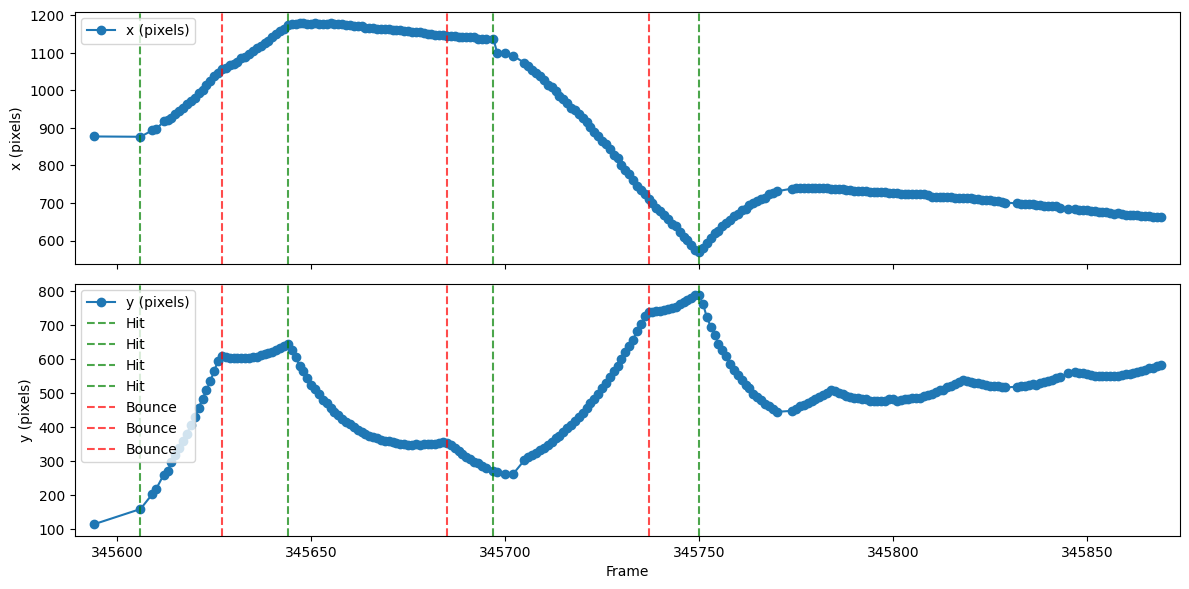

In [50]:
plot_ball_timeseries(123)

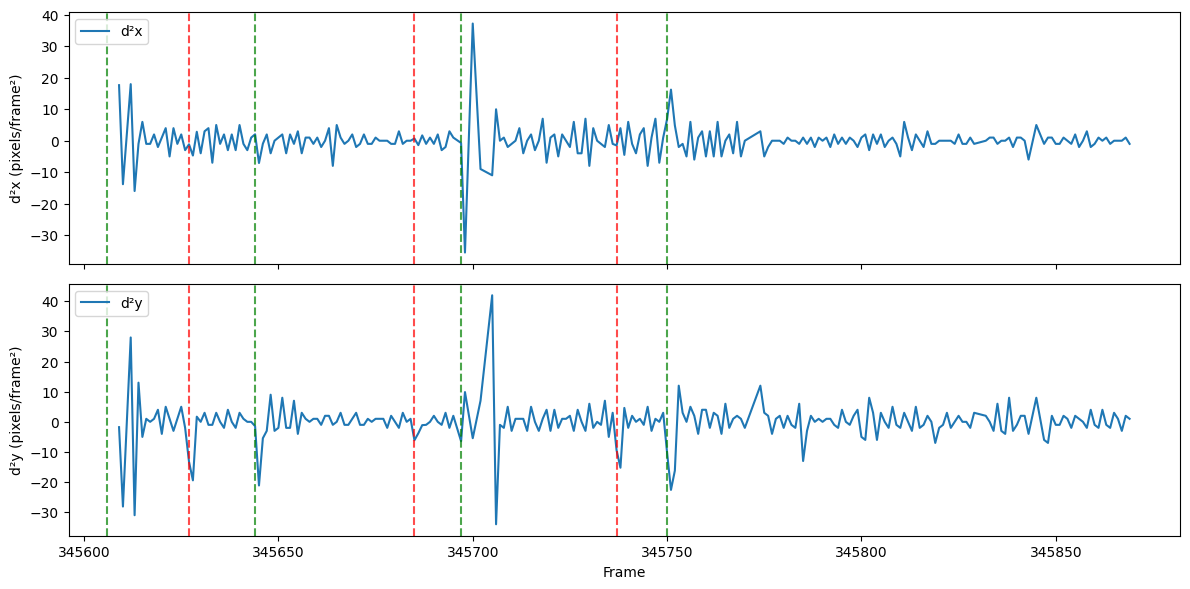

In [51]:
plot_ball_acceleration_timeseries(123)

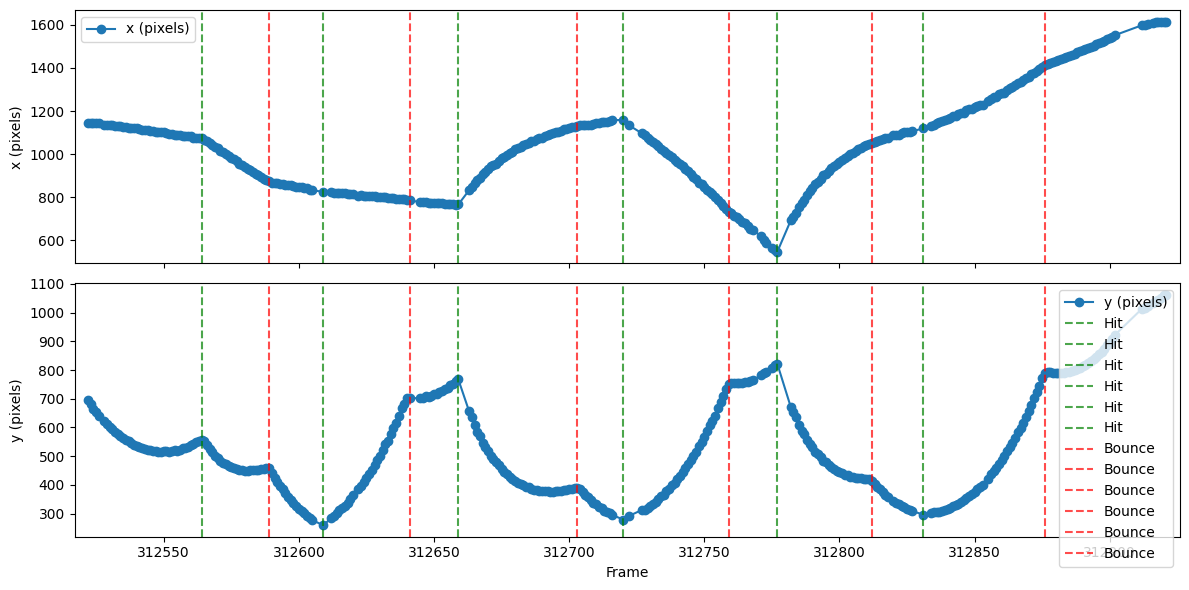

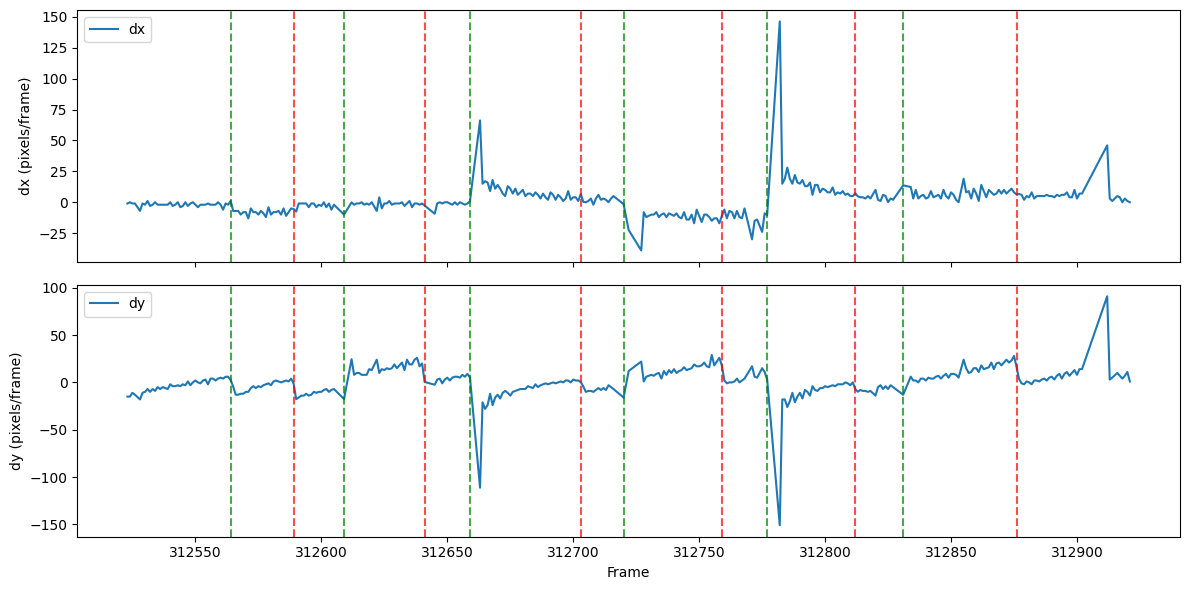

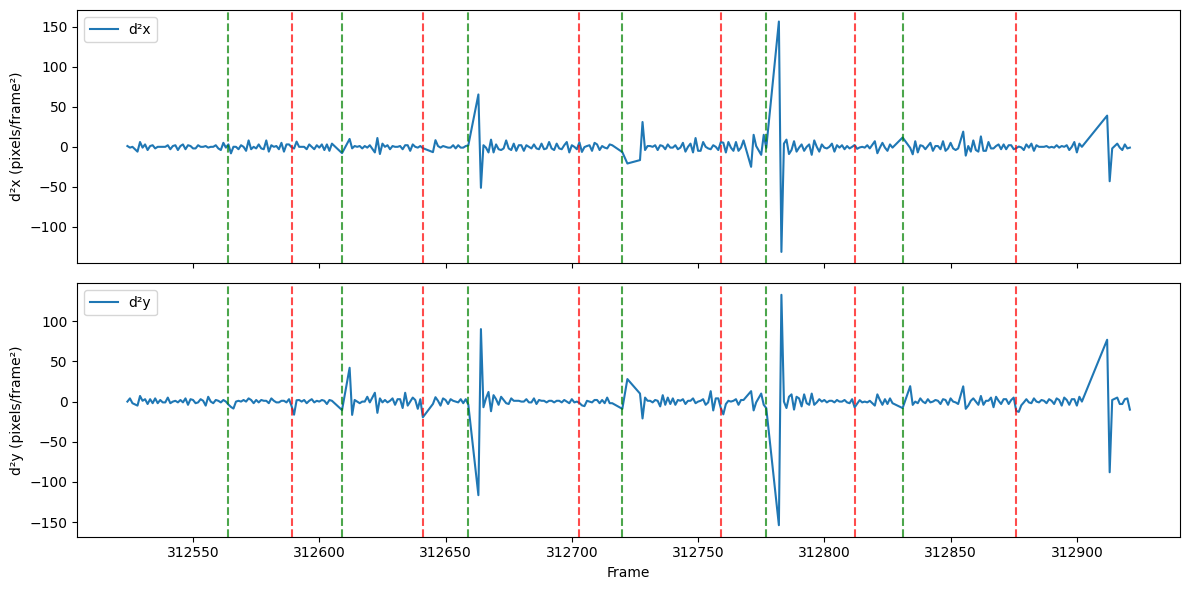

In [52]:
plot_ball_timeseries(point_ID)
plot_ball_velocity_timeseries(point_ID)
plot_ball_acceleration_timeseries(point_ID)

In [ ]:
import numpy as np

def detect_hit_bounce_unsupervised(json_file_title, T_bounce=15):
    """
    Assign pred_action = hit / bounce / air
    based strictly on slope sign changes and jumps,
    following the user's stated rules.
    """
    with open(f"per_point_v2/{json_file_title}.json", "r") as f:
        ball_data = json.load(f)
        
    df_ball_data = (
        pd.DataFrame.from_dict(ball_data, orient="index")
        .reset_index()
        .rename(columns={"index": "frame"}))
    
    df_ball_data = df_ball_data.sort_values("frame")
    
    df_ball_data['dx-'] = df_ball_data["x"] - df_ball_data['x'].shift(1).fillna(0)
    df_ball_data['dx+'] = df_ball_data['x'].shift(-1).fillna(0) - df_ball_data["x"]
    df_ball_data['dy-'] = df_ball_data["y"] - df_ball_data['y'].shift(1).fillna(0)
    df_ball_data['dy+'] = df_ball_data['y'].shift(-1).fillna(0) - df_ball_data["y"]
    

    frames = sorted(ball_data.keys())

    # Initialisation
    for f in frames:
        ball_data[f]["pred_action"] = "air"

    # Frames visibles
    vis_frames = []
    x_vals, y_vals = [], []

    for f in frames:
        d = ball_data[f]
        if d.get("visible") and d.get("x") is not None and d.get("y") is not None:
            vis_frames.append(f)
            x_vals.append(d["x"])
            y_vals.append(d["y"])

    x_vals = np.array(x_vals, dtype=float)
    y_vals = np.array(y_vals, dtype=float)

    if len(x_vals) < 3:
        return ball_data

    dx = np.diff(x_vals)
    dy = np.diff(y_vals)

    ddx = np.diff(dx)
    ddy = np.diff(dy)

    # Parcours frame par frame
    for i in range(1, len(ddx)):
        frame = vis_frames[i + 1]

        dx_prev, dx_now = dx[i - 1], dx[i]
        dy_prev, dy_now = dy[i - 1], dy[i]

        jump_dy = abs(ddy[i])

        # -------- HIT --------
        if dx_prev * dx_now < 0 and dy_prev * dy_now < 0:
            ball_data[frame]["pred_action"] = "hit"

        # -------- BOUNCE --------
        elif (
            dx_prev * dx_now > 0 and
            dy_prev * dy_now > 0 and
            jump_dy > T_bounce
        ):
            ball_data[frame]["pred_action"] = "bounce"

        # -------- AIR --------
        else:
            ball_data[frame]["pred_action"] = "air"

    return ball_data


In [55]:
import json
import os


def compute_event_percentage(folder_path):
    total_visible = 0
    total_events = 0
    total_hit = 0
    total_bounce = 0

    for filename in os.listdir(folder_path):
        if not filename.endswith(".json"):
            continue

        with open(os.path.join(folder_path, filename), "r") as f:
            data = json.load(f)

        for d in data.values():
            if not d.get("visible"):
                continue

            total_visible += 1

            if d.get("action") in ["hit", "bounce"]:
                total_events += 1

            if d.get("action") == "hit":
                total_hit += 1

            elif d.get("action") == "bounce":
                total_bounce += 1

    if total_visible == 0:
        raise ValueError("No visible frames found.")

    return {
        "percent_events": 100 * total_events / total_visible,
        "percent_hit": 100 * total_hit / total_visible,
        "percent_bounce": 100 * total_bounce / total_visible,
        "total_visible_frames": total_visible
    }


In [57]:
dict = compute_event_percentage(folder_path_back)

In [62]:
import os
import json
import numpy as np


MIN_VISIBLE_FRAMES = 30


def compute_T_bounce(folder_path, q=99, method="percentile"):
    """
    Compute T_bounce from AIR frames only.

    Parameters
    ----------
    folder_path : str
        Path to folder containing JSON files.
    method : str
        "percentile" or "mad"
    q : int
        Percentile value if method == "percentile"

    Returns
    -------
    T_bounce : float
    """

    air_delta_dy = []

    for filename in os.listdir(folder_path):
        if not filename.endswith(".json"):
            continue

        with open(os.path.join(folder_path, filename), "r") as f:
            data = json.load(f)

        # Convert frame keys to int and sort
        data = {int(k): v for k, v in data.items()}
        frames = sorted(data.keys())

        # Extract visible x, y and labels
        x_vals, y_vals, labels = [], [], []

        for f in frames:
            d = data[f]
            if d.get("visible") and d.get("x") is not None and d.get("y") is not None:
                x_vals.append(d["x"])
                y_vals.append(d["y"])
                labels.append(d.get("action"))

        if len(x_vals) < MIN_VISIBLE_FRAMES:
            continue

        x_vals = np.array(x_vals, dtype=float)
        y_vals = np.array(y_vals, dtype=float)

        # First derivative
        dy = np.diff(y_vals)

        # Second derivative (jump in slope)
        delta_dy = np.diff(dy)

        # Align labels with delta_dy
        labels_delta = labels[2:]

        for i, label in enumerate(labels_delta):
            if label == "air":
                air_delta_dy.append(abs(delta_dy[i]))

    air_delta_dy = np.array(air_delta_dy)

    if len(air_delta_dy) == 0:
        raise ValueError("No AIR delta_dy found. Cannot compute T_bounce.")

    # ---- Compute threshold ----
    if method == "percentile":
        T_bounce = np.percentile(air_delta_dy, q)

    elif method == "mad":
        med = np.median(air_delta_dy)
        mad = np.median(np.abs(air_delta_dy - med))
        T_bounce = med + 7 * mad

    else:
        raise ValueError("Unknown method. Use 'percentile' or 'mad'.")

    return T_bounce


In [58]:
dict

{'percent_events': 2.679616091772013,
 'percent_hit': 1.40754620710283,
 'percent_bounce': 1.2720698846691827,
 'total_visible_frames': 113673}

In [65]:
Q = dict['percent_events']
T_bounce_cal = compute_T_bounce(folder_path_back,100-Q, 'percentile')

In [93]:
T_bounce_cal

np.float64(35.0)

In [71]:
a = detect_hit_bounce_unsupervised(f'ball_data_{114}', T_bounce_cal)

In [76]:
df_a  = (
    pd.DataFrame.from_dict(a, orient="index")
      .reset_index()
      .rename(columns={"index": "frame"}))

In [83]:
df_a = df_a[df_a["visible"] == True]
df_a = df_a[df_a["action"] == 'bounce']

In [84]:
df_a

,frame,x,y,visible,action,pred_action


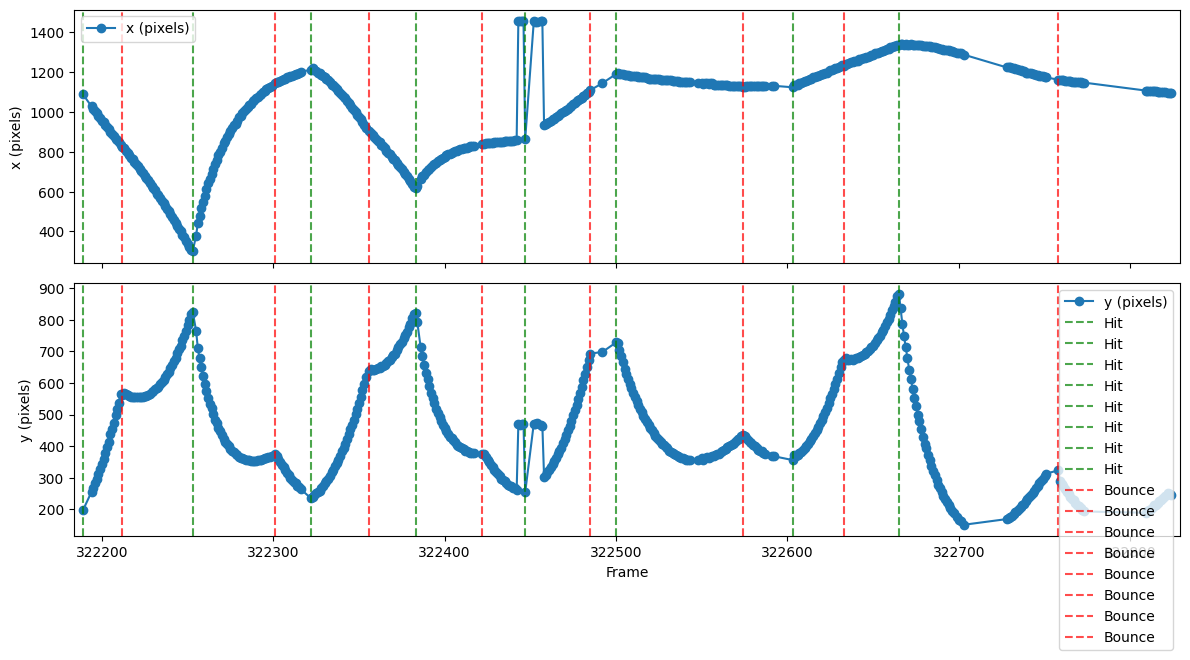

In [85]:
plot_ball_timeseries(114)

In [ ]:
import numpy as np
from collections import defaultdict


def evaluate_hit_bounce_detection(ball_data, ignore_air=False):
    """
    Evaluate model performance using action and pred_action fields.

    Parameters
    ----------
    ball_data : dict
        JSON-like dict with frame_id -> frame_data
    ignore_air : bool
        If True, metrics are computed only on hit and bounce frames.

    Returns
    -------
    results : dict
        Dictionary containing accuracy, confusion matrix,
        precision, recall and F1-score per class.
    """

    y_true = []
    y_pred = []

    for frame, d in ball_data.items():
        if not d.get("visible"):
            continue

        if "action" not in d or "pred_action" not in d:
            continue

        if ignore_air and d["action"] == "air":
            continue

        y_true.append(d["action"])
        y_pred.append(d["pred_action"])

    if len(y_true) == 0:
        raise ValueError("No valid frames to evaluate.")

    labels = sorted(set(y_true) | set(y_pred))
    label_to_idx = {label: i for i, label in enumerate(labels)}

    # ---- Confusion matrix ----
    cm = np.zeros((len(labels), len(labels)), dtype=int)

    for yt, yp in zip(y_true, y_pred):
        cm[label_to_idx[yt], label_to_idx[yp]] += 1

    # ---- Accuracy ----
    accuracy = np.trace(cm) / np.sum(cm)

    # ---- Precision / Recall / F1 ----
    precision = {}
    recall = {}
    f1 = {}

    for label, idx in label_to_idx.items():
        tp = cm[idx, idx]
        fp = cm[:, idx].sum() - tp
        fn = cm[idx, :].sum() - tp

        precision[label] = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall[label] = tp / (tp + fn) if (tp + fn) > 0 else 0.0

        if precision[label] + recall[label] > 0:
            f1[label] = 2 * precision[label] * recall[label] / (precision[label] + recall[label])
        else:
            f1[label] = 0.0

    return {
        "accuracy": accuracy,
        "labels": labels,
        "confusion_matrix": cm,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


# Supervised Models

In [ ]:
def count_visible_frames(json_path):
    with open(json_path, "r") as f:
        data = json.load(f)
    return sum(
        1 for d in data.values()
        if d.get("visible") and d.get("x") is not None and d.get("y") is not None
    )


def split_json_by_visible_frames(folder_path, train_ratio=0.8):
    json_files = [
        os.path.join(folder_path, f)
        for f in os.listdir(folder_path)
        if f.endswith(".json")
    ]

    # Count visible frames per JSON
    json_infos = []
    total_visible = 0

    for path in json_files:
        n_vis = count_visible_frames(path)
        json_infos.append((path, n_vis))
        total_visible += n_vis

    # Sort by decreasing number of visible frames
    json_infos.sort(key=lambda x: x[1], reverse=True)

    train_files = []
    test_files = []
    train_visible = 0
    target_train_visible = train_ratio * total_visible

    for path, n_vis in json_infos:
        if train_visible < target_train_visible:
            train_files.append(path)
            train_visible += n_vis
        else:
            test_files.append(path)

    return train_files, test_files


In [ ]:
import os
import json
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
def get_models():
    return {
        "LogisticRegression": LogisticRegression(
            multi_class="multinomial",
            max_iter=1000,
            class_weight="balanced"
        ),
        "RandomForest": RandomForestClassifier(
            n_estimators=200,
            max_depth=None,
            class_weight="balanced",
            random_state=42
        )
    }


In [ ]:
def extract_features_from_ball_data(ball_data):
    """
    Build features and labels from ONE JSON (one rally).
    """

    frames = sorted(ball_data.keys())

    x_vals, y_vals, labels = [], [], []

    for f in frames:
        d = ball_data[f]
        if d.get("visible") and d.get("x") is not None and d.get("y") is not None:
            x_vals.append(d["x"])
            y_vals.append(d["y"])
            labels.append(d.get("action"))

    x_vals = np.array(x_vals, dtype=float)
    y_vals = np.array(y_vals, dtype=float)

    if len(x_vals) < 3:
        return None, None

    dx = np.diff(x_vals)
    dy = np.diff(y_vals)

    ddx = np.diff(dx)
    ddy = np.diff(dy)

    X, y = [], []

    for i in range(1, len(ddx)):
        features = [
            dx[i], dy[i],
            abs(dx[i]), abs(dy[i]),
            ddx[i], ddy[i],
            np.sqrt(dx[i]**2 + dy[i]**2),
            int(dx[i-1] * dx[i] < 0),
            int(dy[i-1] * dy[i] < 0),
        ]

        X.append(features)
        y.append(labels[i + 1])

    return np.array(X), np.array(y)


In [ ]:
def build_dataset(json_files):
    X_all, y_all = [], []

    for path in json_files:
        with open(path, "r") as f:
            ball_data = json.load(f)
        ball_data = {int(k): v for k, v in ball_data.items()}

        X, y = extract_features_from_ball_data(ball_data)

        if X is None:
            continue

        X_all.append(X)
        y_all.append(y)

    return np.vstack(X_all), np.hstack(y_all)


In [ ]:
def train_and_evaluate(train_files, test_files):

    # ---- Build datasets ----
    X_train, y_train = build_dataset(train_files)
    X_test, y_test = build_dataset(test_files)

    print("Train size:", X_train.shape)
    print("Test size :", X_test.shape)

    models = get_models()

    for name, model in models.items():
        print(f"\n===== {name} =====")

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        print(classification_report(y_test, y_pred, digits=3))
        print("Confusion matrix:")
        print(confusion_matrix(y_test, y_pred))


In [ ]:
train_files, test_files = split_json_by_visible_frames(
    folder_path_back,
    train_ratio=0.8
)

train_and_evaluate(train_files, test_files)
